# Plots for dissertation

In [1]:
import sys
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import proplot as pplt
import seaborn as sns
from tqdm import tqdm

sys.path.append('/Users/46h/Research/')
from scdist.tools import animation as myanim
from scdist.tools import beam_analysis as ba
from scdist.tools import plotting as myplt
from scdist.tools import utils

In [2]:
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid.alpha'] = 0.04
pplt.rc['axes.grid'] = False
pplt.rc['animation.html'] = 'jshtml'
pplt.rc['savefig.dpi'] = 'figure'
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['cmap.discrete'] = False
savefig_kws = dict(dpi=300)

In [3]:
bins = 'auto'
thresh = 0.
cmap = pplt.Colormap('mono', left=0.035)

## Incoherent effects 

In [21]:
tunes = np.loadtxt('_saved/gaussian_tune100-90/tunes.dat')
# coords = np.load('_saved/gaussian_tune100-90/coords.npy')
coords = np.load('_output/data/coords.npy')

In [23]:
stats = ba.BeamStats()
stats.read_coords(coords)

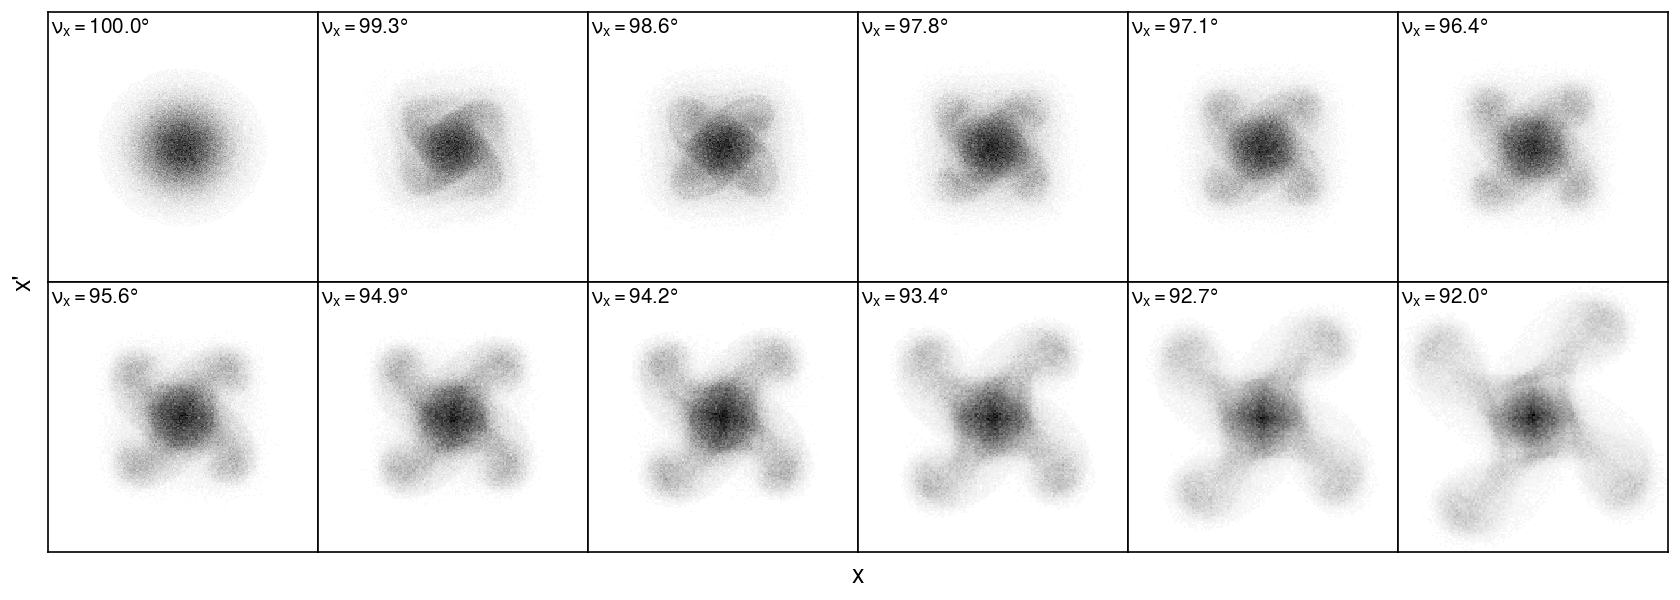

In [30]:
scale = 1.0
xmax = np.max(coords[frames, :, 0])
xpmax = np.max(coords[frames, :, 1])
xmax, xpmax = scale * np.array([xmax, xpmax])

frames = np.linspace(0, 400, 12).astype(int)
ncols = 6
nrows = len(frames) // ncols
cmap = pplt.Colormap('mono', left=0.025)

fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=8.4, space=0.)
axes.format(xticks=[], yticks=[], xlabel="x", ylabel="x'")
for frame, ax in zip(frames, axes):
    X = coords[frame]
    tune_x, tune_y = tunes[frame]
    xedges = np.histogram_bin_edges(X[:, 0], bins, (-xmax, xmax))
    yedges = np.histogram_bin_edges(X[:, 1], bins, (-xpmax, xpmax))
    Z, _, _ = np.histogram2d(X[:, 0], X[:, 1], [xedges, yedges])
    if thresh is not None:
        Z = np.ma.masked_less_equal(Z, thresh)
    ax.pcolormesh(xedges, yedges, Z.T, ec='none', cmap=cmap)
    ax.annotate(r'$\nu_x = {:.1f}\degree$'.format(tune_x), xy=(0.01, 0.92), 
                xycoords='axes fraction', fontsize='small', color='black')
    plt.savefig('_output/figures/incoherent_resonance_fourth_order.png', **savefig_kws)
plt.show()

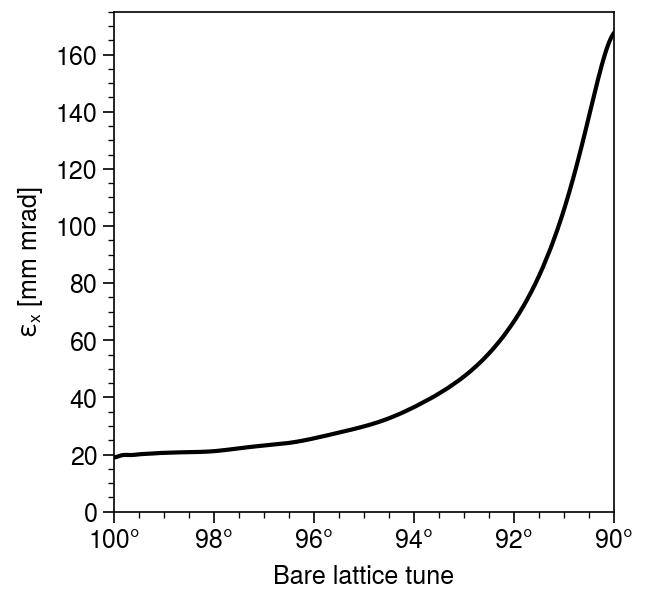

In [27]:
fig, ax = pplt.subplots(figsize=None)
emittances = stats.twiss2D.loc[:, 'eps_x'].values
ax.plot(tunes[:, 0], emittances[1:], color='black')
ax.format(ylabel=r'$\varepsilon_x$ [mm mrad]', xlabel='Bare lattice tune', xformatter='deg', ylim=(0., ax.get_ylim()[1]))
plt.savefig('_output/figures/incoherent_resonance_fourth_order_emittance.png', **savefig_kws)
plt.show()

## Coherent effects 

### Envelope instability 

In [ ]:
depressed_tunes = np.loadtxt('_output/data/depressed_tunes.dat')
sizes_list = np.load('_output/data/sizes_list.npy')
sizes_list *= 1000.

In [ ]:
n = len(depressed_tunes)

In [ ]:
with pplt.rc.context(legendfontsize='medium'):

    fig, axes = pplt.subplots(nrows=3, ncols=2, figsize=(7.0, 4.5))
    plot_kws = dict(lw=0.3)
    for i in range(n):
        ax = axes[i]
        xrms, yrms = sizes_list[i].T
        h1 = ax.plot(xrms, **plot_kws)
        h2 = ax.plot(yrms, **plot_kws)
        ax.annotate(
            r'$\nu_x = {:.1f}\degree$'.format(depressed_tunes[i]),
            xy=(0.01, 0.87), xycoords='axes fraction', fontsize='small'
        )
    axes.format(ylim=(0., umax))
    axes.format(xlabel='Cell number', ylabel='[mm]')
    axes[0].legend(
        handles=[h1, h2],
        labels=[r'$\sqrt{\langle{x^2}\rangle}$', r'$\sqrt{\langle{y^2}\rangle}$'], 
        loc=(0., 1.01), ncols=2, framealpha=0., lw=1
    )
    plt.savefig('_output/figures/envelope_instability.png', **savefig_kws)
    plt.show()

In [31]:
del coords

### Higher-order

In [48]:
coords_list1 = [
    np.load('_saved/mu0-90_mu-45_kv/coords.npy'),
    np.load('_saved/mu0-90_mu-45_wb/coords.npy'),
    np.load('_saved/mu0-90_mu-45_gauss/coords.npy'),
]
coords_list2 = [
    np.load('_saved/mu0-90_mu-30_kv/coords.npy'),
    np.load('_saved/mu0-90_mu-30_wb/coords.npy'),
    np.load('_saved/mu0-90_mu-30_gauss/coords.npy'),
]

stats_list1 = []
for coords in tqdm(coords_list1):
    stats = ba.BeamStats()
    stats.read_coords(coords)
    stats_list1.append(stats)

stats_list2 = []
for coords in tqdm(coords_list2):
    stats = ba.BeamStats()
    stats.read_coords(coords)
    stats_list2.append(stats)

100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


#### Emittance growth 

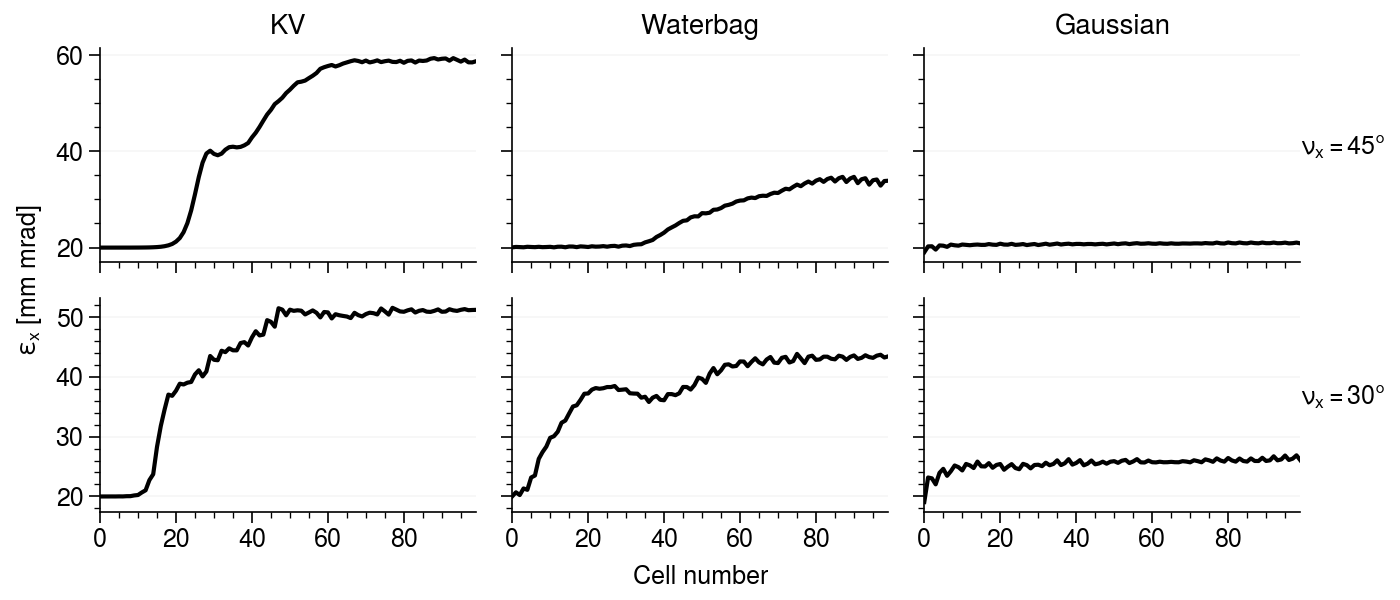

In [49]:
fig, axes = pplt.subplots(nrows=2, ncols=3, figsize=(7, 3))

myplt.despine(axes, ('top', 'right'))
axes.format(xlabel="Cell number", ylabel=r"$\varepsilon_x$ [mm mrad]", ygrid=True)
for ax, title in zip(axes[0, :], ['KV', 'Waterbag', 'Gaussian']):
    ax.set_title(title)
axes[0, -1].annotate(r'$\nu_{x} = 45\degree$', xy=(1, 0.5), xycoords='axes fraction')
axes[1, -1].annotate(r'$\nu_{x} = 30\degree$', xy=(1, 0.5), xycoords='axes fraction')

for i, stats_list in enumerate([stats_list1, stats_list2]):
    for ax, stats in zip(axes[i, :], stats_list):
        h1 = ax.plot(stats.twiss2D['eps_x'].values, color='black')
        
# axes[0, -1].legend(
#     handles=[h1, h2],
#     labels=[r'$\varepsilon_x$', r'$\varepsilon_y$'],
#     ncols=1, 
#     handlelength=1.25, 
#     fontsize='small', 
#     loc=(1.0, 0.8),
# )
plt.savefig('_output/figures/coherent_instability_emittances.png', **savefig_kws)
plt.show()

#### Phase space

In [50]:
cmap = pplt.Colormap('mono', left=0.030)

100%|██████████| 7/7 [00:00<00:00, 19.27it/s]


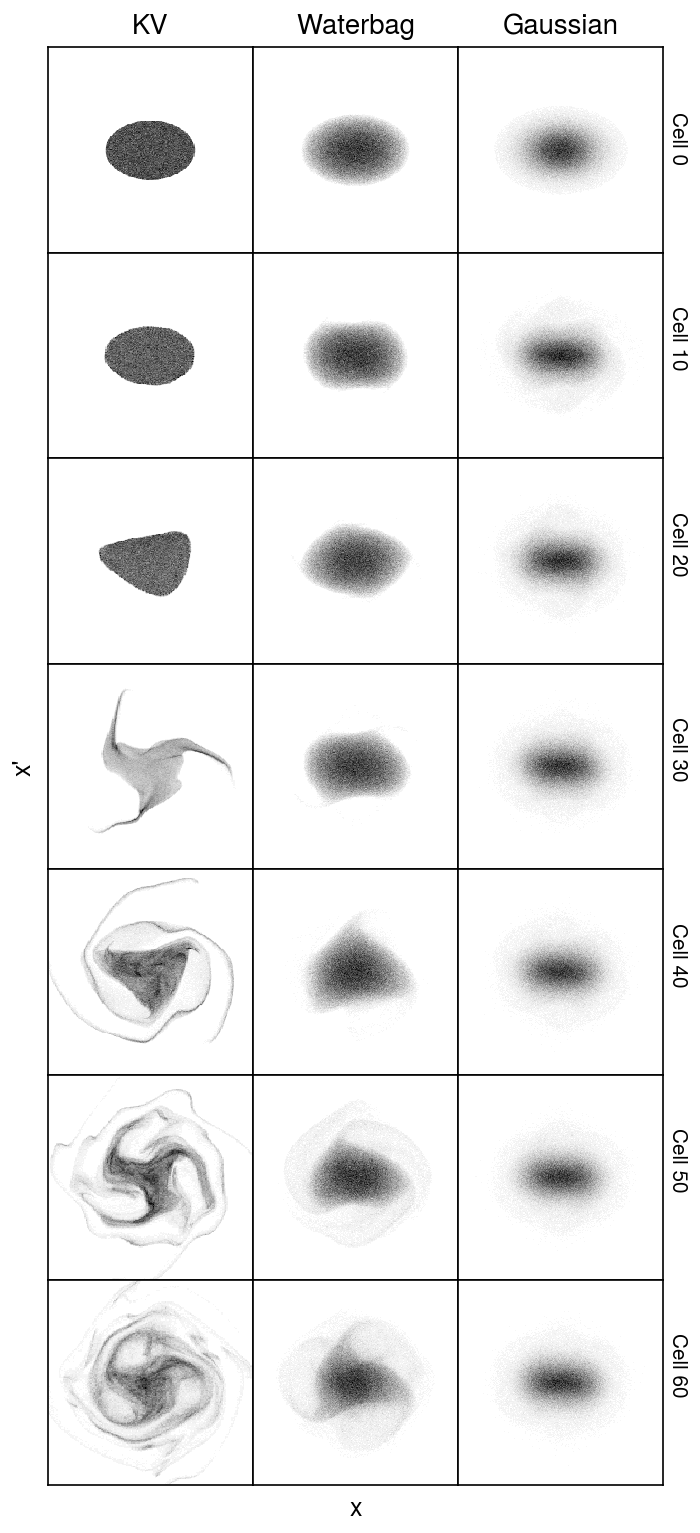

100%|██████████| 7/7 [00:00<00:00, 19.86it/s]


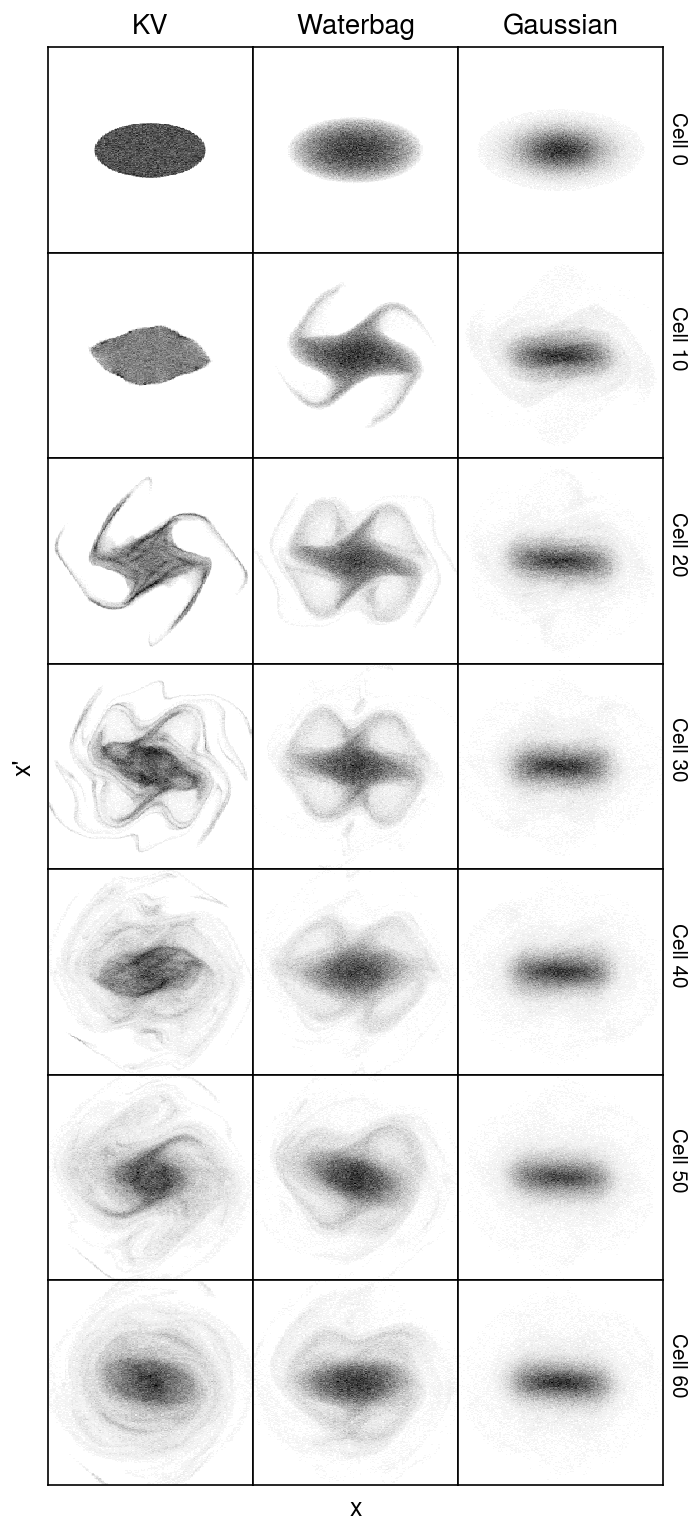

In [51]:
frames = list(range(0, 70, 10))
scale = 0.8
for coords_list, name in zip([coords_list1, coords_list2], ['fourth_order', 'third_order']):
    xmax = scale * max([np.max(coords[:, :, 0]) for coords in coords_list])
    xpmax = scale * max([np.max(coords[:, :, 1]) for coords in coords_list])
    
    fig, axes = pplt.subplots(nrows=len(frames), ncols=3, figwidth=3.5, space=0.)
    axes.format(xticks=[], yticks=[], xlabel="x", ylabel="x'")
    for j, coords in enumerate(coords_list):
        axes[0, j].set_title(['KV', 'Waterbag', 'Gaussian'][j])
        for i, frame in enumerate(tqdm(frames)):
            X = coords[frame]
            xedges = np.histogram_bin_edges(X[:, 0], bins, (-xmax, xmax))
            yedges = np.histogram_bin_edges(X[:, 1], bins, (-xpmax, xpmax))
            Z, _, _ = np.histogram2d(X[:, 0], X[:, 1], [xedges, yedges])
            if thresh is not None:
                Z = np.ma.masked_less_equal(Z, thresh)
            axes[i, j].pcolormesh(xedges, yedges, Z.T, cmap=cmap, ec='none')
            
            if j == 2:
                text = 'Cell {}'.format(frame)
                axes[i, j].annotate(
                    text,
                    xy=(1.02, 0.45), 
                    xycoords='axes fraction',
                    fontsize='small', 
                    rotation=-90,
                )
    plt.savefig('_output/figures/coherent_instability_{}.png'.format(name), **savefig_kws)
    plt.show()